<a href="https://colab.research.google.com/github/ziatdinovmax/hypoAL/blob/main/hypoAL_paper_Algo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

In [ ]:
#@title Imports
from typing import Union, Dict, Type

import gpax

import jax.numpy as jnp
import jax.random as jra
import numpy as onp
import numpyro
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

In [3]:
#@title Plotting and data utilities { form-width: "20%" }

def get_training_data(X, Y, num_seed_points=2, rng_seed=42, **kwargs):
    onp.random.seed(rng_seed)
    indices = jnp.arange(len(X))
    idx = kwargs.get("list_of_indices")
    if idx is not None:
        idx = onp.array(idx)
    else:
        idx = onp.random.randint(0, len(X), num_seed_points)
    idx = onp.unique(idx)
    X_train, y_train = X[idx], Y[idx]
    indices_train = indices[idx]
    X_test = jnp.delete(X, idx)
    y_test = jnp.delete(Y, idx)
    indices_test = jnp.delete(indices, idx)
    return X_train, y_train, X_test, y_test, indices_train, indices_test
    

def plot_results(X_measured, y_measured, X_unmeasured, y_pred, y_sampled, obj, model_idx, rewards, **kwargs):
    X = jnp.concatenate([X_measured, X_unmeasured], axis=0).sort()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X_measured, y_measured, marker='x', s=100, c='k', label="Measured points", zorder=1)
    ax1.plot(X, y_pred, c='red', label='Model reconstruction', zorder=0)
    ax1.fill_between(X, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                     color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    ax1.set_xlabel("$x$", fontsize=18)
    ax1.set_ylabel("$y$", fontsize=18)
    ax2.plot(X_unmeasured, obj, c='k')
    ax2.vlines(X_unmeasured[obj.argmax()], obj.min(), obj.max(), linestyles='dashed', label= "Next point")
    ax2.set_xlabel("$x$", fontsize=18)
    ax2.set_ylabel("Acquisition function", fontsize=18)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper left")
    step = kwargs.get("e", 0)
    plt.suptitle("Step: {},  Sampled Model: {}, Rewards: {}".format(
        step+1, model_idx, onp.around(rewards, 3).tolist()), fontsize=24)
    fig.savefig("./{}.png".format(step))
    plt.show() 
    

def plot_acq(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.vlines(x[idx], obj.min(), obj.max(), linestyles='dashed')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()
    

def plot_final_result(X, y, X_test, y_pred, y_sampled, seed_points):
    plt.figure(dpi=100)
    plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
                cmap='viridis', label="Sampled points", zorder=2)
    cbar = plt.colorbar(label="Exploration step")
    cbar_ticks = jnp.arange(2, len(X[seed_points:]) + 1, 2)
    cbar.set_ticks(cbar_ticks)
    plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
                c='k', label="Seed points", zorder=1)
    plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=1)
    plt.plot(X_test, truefunc, c='k', label="Ground truth", zorder=0)
    plt.fill_between(X_test, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                            color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    plt.xlabel("$x$", fontsize=12)
    plt.ylabel("$y$", fontsize=12)
    plt.legend(fontsize=9, loc='upper left')
    #plt.ylim(1.8, 6.6)
    plt.show()

Generate data:

Text(0, 0.5, '$y$')

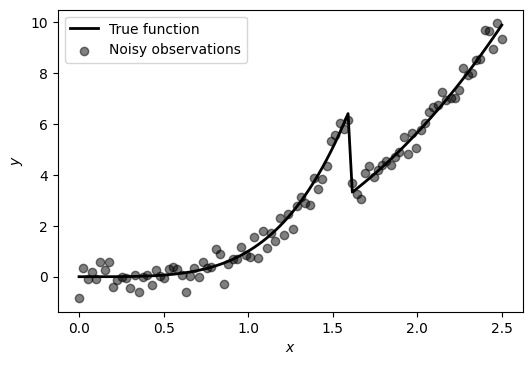

In [4]:
def function_(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


X = jnp.linspace(0.0, 2.5, 100)
params = {"t": 1.6, "beta1": 4, "beta2": 2.5}

truefunc = function_(X, params)
Y = truefunc + 0.33 * jra.normal(jra.PRNGKey(0), shape=truefunc.shape)

_, ax = plt.subplots(dpi=100)            
ax.scatter(X, Y, alpha=0.5, c='k', label="Noisy observations")
ax.plot(X, truefunc, lw=2, c='k', label="True function")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

Define models as dereministic functions:

In [5]:
def piecewise1(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta"], lambda x: params["c"]*x])
    
def piecewise2(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: params["b"]*x, lambda x: params["c"]*x])
    
def piecewise3(x: jnp.ndarray, params: Dict[str, jnp.ndarray]) -> jnp.ndarray:
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])

Put priors over parameters of each model (to make them probabilistic):

In [6]:
def piecewise1_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta = numpyro.sample("beta", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta": beta, "c": c}

def piecewise2_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    b = numpyro.sample("b", numpyro.distributions.Normal(3, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "b": b, "c": c}

def piecewise3_priors() -> Dict[str, jnp.ndarray]:
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.0))
    beta1 = numpyro.sample("beta1", numpyro.distributions.Normal(3, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.Normal(3, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}

Let's also specify custom priors over GP kernel:

In [7]:
 def gp_kernel_prior() -> Dict[str, jnp.ndarray]:
     length = numpyro.sample("k_length", numpyro.distributions.Uniform(0, 1))
     scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
     return {"k_length": length, "k_scale": scale}

Helper functions specific to exploration (will likely need to modify/customize them many times):

In [8]:
def get_best_model(record):
    return record[:,1].argmax()

def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    if jnp.nanmedian(obj) < obj_history[-1]:  # one can use integral uncertainty instead of median
        r = 1
    else:
        r = -1
    return r

def step(model, model_prior, X_train, y_train, X_new=None, num_restarts=1, **kwargs):
    """Compute model posterior and use it to derive acqusition function"""
    acq_fn = gpax.acquisition.UE
    verbose = kwargs.get("print_summary", True)
    sgr = numpyro.diagnostics.split_gelman_rubin
    for i in range(num_restarts):
        rng_key, rng_key_predict = gpax.utils.get_keys(i)
        # Get/update model posterior. In the paper, we used
        # num_samples = num_warmup = 5000 but that takes some time
        gp_model = gpax.ExactGP(
            1, 'Matern', kernel_prior=gp_kernel_prior,
            mean_fn=model, mean_fn_prior=model_prior)
        gp_model.fit(
            rng_key, X_train, y_train, num_warmup=2000,
            num_samples=2000, num_chains=1, print_summary=verbose)
        rhats = [sgr(v).item() for v in gp_model.get_samples(1).values()]
        if max(rhats) < 1.1:
            break 
    # Compute acquisition function
    obj = 0
    if X_new is not None:
        obj = acq_fn(rng_key_predict, gp_model, X_new)
    return obj, gp_model

def update_datapoints(next_point_idx, train, test):
    """Update "measured" dummy data points"""
    X_train, y_train, indices_train = train
    X_test, y_test, indices_test = test
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, y_test[next_point_idx])
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point_idx)
    indices_test = jnp.delete(indices_test, next_point_idx)
    return (X_train, y_train, indices_train), (X_test, y_test, indices_test)

Generate seed points:

In [9]:
(X_train, y_train, X_test, y_test,
     indices_train, indices_test) = get_training_data(X, Y, list_of_indices=[0, 33, 66, 99])
num_seed_points = len(X_train)

The main part (Algorithm 1 in the paper):

Warmup step 1/3


sample: 100%|██████████| 4000/4000 [00:21<00:00, 188.38it/s, 1023 steps of size 3.23e-04. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.40      0.65      2.42      1.41      3.49     25.82      1.00
         c      3.50      0.54      3.56      2.54      4.29      6.28      1.29
  k_length      0.41      0.27      0.35      0.02      0.84     16.66      1.00
   k_scale      1.22      1.39      0.75      0.08      2.68     16.14      1.09
     noise      0.95      0.64      0.79      0.10      1.86     38.32      1.01
         t      1.61      0.42      1.78      0.85      2.00      7.57      1.23

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:20<00:00, 199.60it/s, 1023 steps of size 8.53e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.43      0.74      2.36      1.26      3.67     86.68      1.00
         c      3.45      0.52      3.48      2.61      4.30     66.49      1.04
  k_length      0.53      0.29      0.52      0.11      0.98     87.66      1.00
   k_scale      1.23      1.28      0.83      0.06      2.57    107.19      1.01
     noise      1.27      1.16      0.93      0.04      2.68    105.98      1.00
         t      1.55      0.44      1.73      0.79      2.00     66.49      1.01

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:07<00:00, 551.61it/s, 15 steps of size 2.93e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      2.82      0.97      2.76      1.11      4.31   1011.90      1.00
     beta2      2.42      0.15      2.43      2.19      2.68   1137.04      1.00
  k_length      0.51      0.29      0.52      0.08      0.96   1729.59      1.00
   k_scale      0.90      0.98      0.63      0.05      1.86   1112.96      1.00
     noise      0.87      0.85      0.61      0.06      1.80   1187.95      1.00
         t      1.17      0.41      1.15      0.52      1.74   1426.05      1.00

Number of divergences: 168
Warmup step 2/3


sample: 100%|██████████| 4000/4000 [00:09<00:00, 431.03it/s, 63 steps of size 4.77e-02. acc. prob=0.83] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      3.01      0.91      2.99      1.42      4.43    795.72      1.00
         c      3.28      0.50      3.26      2.47      4.13   1041.71      1.00
  k_length      0.43      0.30      0.39      0.00      0.86   1140.26      1.00
   k_scale      1.19      1.12      0.82      0.06      2.55   1153.11      1.00
     noise      1.92      1.46      1.55      0.14      3.60   1259.80      1.00
         t      1.25      0.39      1.24      0.69      1.97   1100.45      1.00

Number of divergences: 23


sample: 100%|██████████| 4000/4000 [00:07<00:00, 503.04it/s, 63 steps of size 7.47e-02. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.74      0.90      2.71      1.17      4.08    907.21      1.00
         c      3.27      0.53      3.28      2.41      4.13    934.57      1.00
  k_length      0.44      0.31      0.41      0.00      0.89   1187.18      1.00
   k_scale      1.27      1.21      0.89      0.08      2.61   1116.57      1.00
     noise      2.01      1.59      1.62      0.19      3.73   1122.47      1.00
         t      1.27      0.44      1.27      0.65      1.99    972.00      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:27<00:00, 145.07it/s, 1023 steps of size 1.89e-04. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.77      0.33      3.80      3.19      4.25     13.26      1.07
     beta2      2.47      0.13      2.51      2.26      2.66      3.63      1.83
  k_length      0.41      0.29      0.38      0.02      0.83     11.25      1.00
   k_scale      0.60      0.37      0.55      0.10      1.02     15.58      1.02
     noise      0.94      0.82      0.57      0.07      2.18      3.04      2.05
         t      1.60      0.07      1.61      1.53      1.67     21.42      1.07

Number of divergences: 0
Warmup step 3/3


sample: 100%|██████████| 4000/4000 [00:20<00:00, 196.18it/s, 1023 steps of size 4.22e-03. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.97      0.87      2.93      1.62      4.49    946.64      1.00
         c      3.24      0.52      3.22      2.31      4.05    658.30      1.00
  k_length      0.43      0.30      0.38      0.00      0.87    965.49      1.00
   k_scale      1.22      1.22      0.87      0.05      2.58    869.36      1.00
     noise      1.75      1.25      1.41      0.21      3.20   1144.00      1.00
         t      1.30      0.41      1.30      0.71      1.99    658.80      1.00

Number of divergences: 42


sample: 100%|██████████| 4000/4000 [00:10<00:00, 386.95it/s, 127 steps of size 2.38e-02. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.72      0.83      2.71      1.29      4.03   1097.06      1.00
         c      3.26      0.52      3.25      2.39      4.06    729.88      1.00
  k_length      0.46      0.30      0.44      0.00      0.90    929.08      1.00
   k_scale      1.35      1.31      0.96      0.08      2.89   1031.29      1.00
     noise      1.73      1.21      1.46      0.17      3.25   1202.52      1.00
         t      1.31      0.44      1.34      0.67      2.00    829.92      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:33<00:00, 119.54it/s, 1023 steps of size 2.00e-03. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.26      0.79      3.43      1.91      4.39     29.97      1.08
     beta2      2.43      0.14      2.44      2.21      2.65     42.75      1.07
  k_length      0.45      0.29      0.43      0.00      0.87    198.29      1.00
   k_scale      0.93      0.94      0.64      0.06      2.03     64.92      1.05
     noise      1.19      0.91      0.95      0.12      2.27     87.36      1.06
         t      1.46      0.27      1.58      0.84      1.73      7.14      1.25

Number of divergences: 0
Exploration step 4/15
Using model 1


sample: 100%|██████████| 4000/4000 [00:11<00:00, 359.79it/s, 31 steps of size 9.55e-02. acc. prob=0.80] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.95      0.95      2.97      1.36      4.48    860.76      1.00
         c      3.26      0.47      3.26      2.46      4.03    668.73      1.00
  k_length      0.43      0.30      0.40      0.00      0.88    797.26      1.00
   k_scale      1.21      1.23      0.84      0.08      2.61    942.28      1.00
     noise      1.89      1.30      1.58      0.21      3.53    916.75      1.00
         t      1.21      0.37      1.20      0.51      1.74   1145.71      1.00

Number of divergences: 32


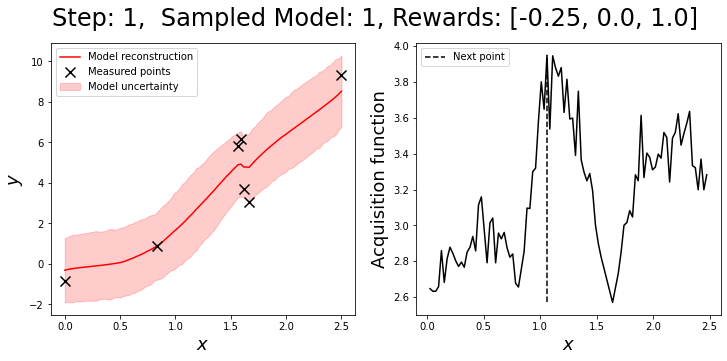

Exploration step 5/15
Using model 3


sample: 100%|██████████| 4000/4000 [00:41<00:00, 95.69it/s, 1023 steps of size 4.28e-04. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.83      0.24      3.83      3.38      4.15     27.59      1.05
     beta2      2.44      0.11      2.44      2.27      2.64     17.13      1.10
  k_length      0.45      0.30      0.42      0.01      0.89     17.50      1.00
   k_scale      0.61      0.55      0.45      0.03      1.18     37.87      1.03
     noise      0.47      0.31      0.40      0.05      0.86     27.86      1.04
         t      1.60      0.01      1.60      1.59      1.61     79.55      1.01

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [00:41<00:00, 95.74it/s, 1023 steps of size 5.22e-04. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.90      0.25      3.90      3.47      4.27     48.33      1.00
     beta2      2.44      0.13      2.45      2.21      2.66     18.89      1.21
  k_length      0.51      0.30      0.50      0.10      1.00     34.98      1.05
   k_scale      0.59      0.49      0.46      0.05      1.19     42.76      1.01
     noise      0.60      0.43      0.50      0.12      1.06     74.06      1.01
         t      1.60      0.01      1.61      1.59      1.62    217.74      1.00

Number of divergences: 0


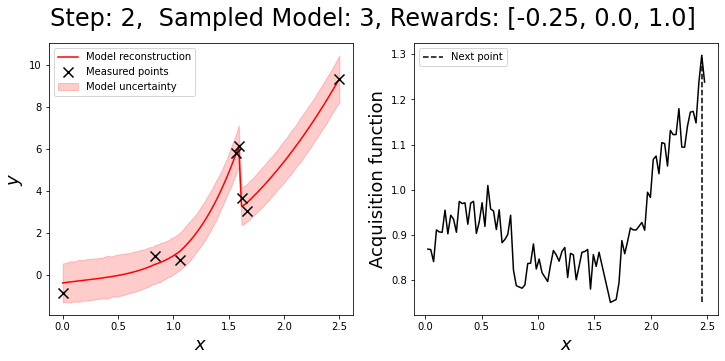

Exploration step 6/15
Using model 2


sample: 100%|██████████| 4000/4000 [00:39<00:00, 100.40it/s, 1023 steps of size 1.84e-03. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.49      0.88      2.51      1.10      3.97    303.96      1.00
         c      3.39      0.46      3.38      2.65      4.19    429.52      1.01
  k_length      0.47      0.31      0.46      0.01      0.92    305.00      1.00
   k_scale      1.35      1.28      0.98      0.05      2.70    497.52      1.00
     noise      1.69      1.01      1.47      0.20      3.05    353.17      1.00
         t      1.30      0.40      1.31      0.70      1.99    371.47      1.00

Number of divergences: 0


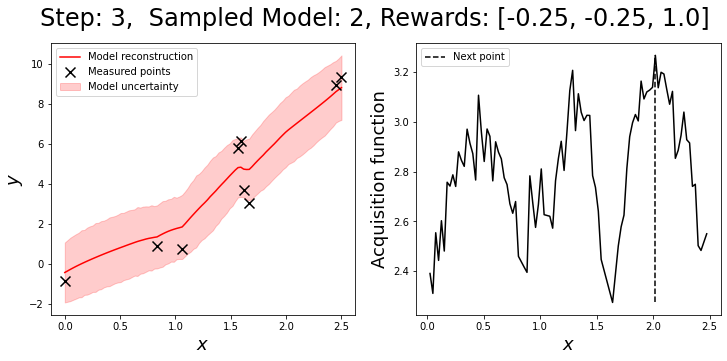

Exploration step 7/15
Using model 3


sample: 100%|██████████| 4000/4000 [00:56<00:00, 70.21it/s, 1023 steps of size 2.40e-03. acc. prob=0.78]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.73      0.45      3.84      3.16      4.31     32.66      1.09
     beta2      2.44      0.10      2.44      2.29      2.60    538.10      1.00
  k_length      0.50      0.30      0.50      0.04      0.93    264.90      1.00
   k_scale      0.64      0.61      0.46      0.02      1.32     95.74      1.01
     noise      0.52      0.59      0.33      0.05      1.08     24.00      1.06
         t      1.58      0.08      1.60      1.57      1.70     14.70      1.08

Number of divergences: 0


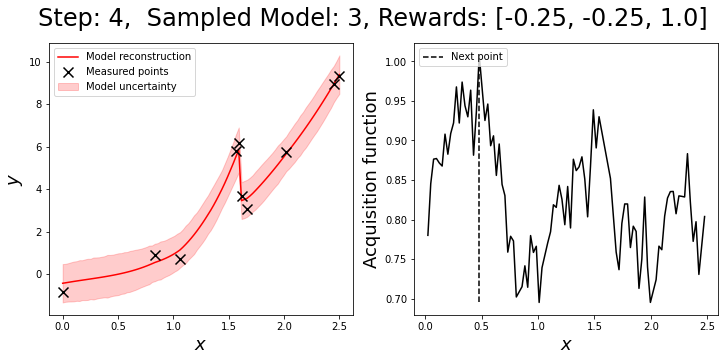

Exploration step 8/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:07<00:00, 58.83it/s, 1023 steps of size 1.38e-03. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.85      0.20      3.87      3.51      4.15    231.78      1.00
     beta2      2.44      0.09      2.44      2.28      2.58    179.78      1.01
  k_length      0.53      0.30      0.56      0.10      1.00     75.22      1.00
   k_scale      0.53      0.55      0.35      0.04      1.12    175.01      1.01
     noise      0.34      0.24      0.27      0.05      0.65    122.77      1.00
         t      1.60      0.01      1.60      1.59      1.62    161.92      1.00

Number of divergences: 0


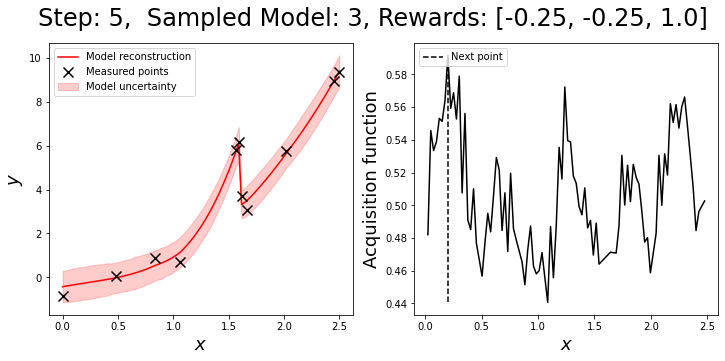

Exploration step 9/15
Using model 2


sample: 100%|██████████| 4000/4000 [00:55<00:00, 72.06it/s, 1023 steps of size 9.15e-04. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.44      0.76      2.41      1.17      3.62    164.81      1.00
         c      3.36      0.46      3.34      2.58      4.03     65.26      1.04
  k_length      0.52      0.30      0.52      0.03      0.93    106.29      1.00
   k_scale      1.28      1.07      0.97      0.09      2.51    146.82      1.00
     noise      1.36      0.70      1.21      0.38      2.35    111.18      1.00
         t      1.30      0.40      1.30      0.68      2.00     45.56      1.00

Number of divergences: 0


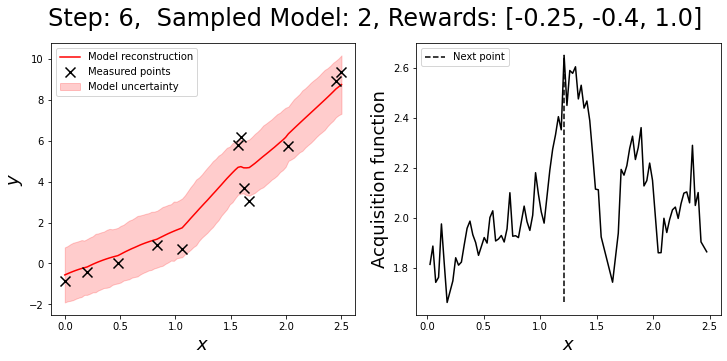

Exploration step 10/15
Using model 1


sample: 100%|██████████| 4000/4000 [01:18<00:00, 50.89it/s, 1023 steps of size 5.22e-04. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      4.15      0.38      4.23      3.47      4.68      7.28      1.23
         c      3.21      0.38      3.25      2.57      3.74      5.89      1.29
  k_length      0.49      0.28      0.46      0.11      0.97     14.30      1.05
   k_scale      1.41      1.29      1.03      0.11      2.69     17.92      1.09
     noise      0.58      0.53      0.34      0.03      1.33      3.32      1.76
         t      1.60      0.04      1.60      1.51      1.67      9.11      1.02

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [01:19<00:00, 50.46it/s, 1023 steps of size 2.36e-03. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      4.04      0.61      4.20      3.09      4.77     21.33      1.03
         c      3.16      0.42      3.17      2.43      3.78    139.06      1.02
  k_length      0.52      0.26      0.52      0.15      1.00    342.21      1.00
   k_scale      1.27      1.17      0.98      0.07      2.52     63.58      1.02
     noise      0.63      0.56      0.43      0.05      1.42     17.11      1.03
         t      1.59      0.04      1.60      1.49      1.62     11.75      1.08

Number of divergences: 0


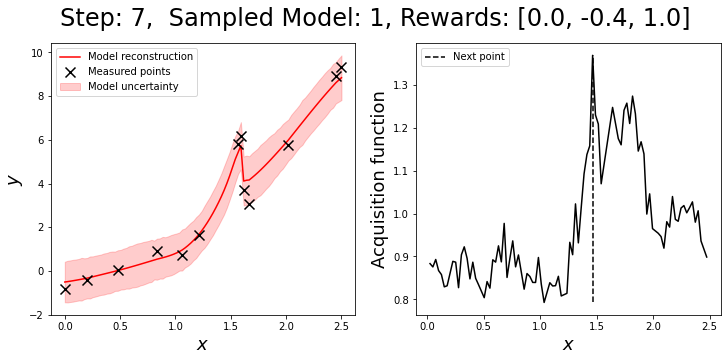

Exploration step 11/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:33<00:00, 42.87it/s, 1023 steps of size 1.59e-03. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.89      0.16      3.89      3.63      4.15    275.31      1.00
     beta2      2.44      0.09      2.44      2.29      2.57    190.65      1.00
  k_length      0.57      0.28      0.61      0.15      1.00     91.04      1.00
   k_scale      0.48      0.50      0.34      0.03      0.99    253.64      1.00
     noise      0.22      0.14      0.19      0.05      0.41    206.49      1.00
         t      1.60      0.01      1.60      1.59      1.61    354.38      1.00

Number of divergences: 0


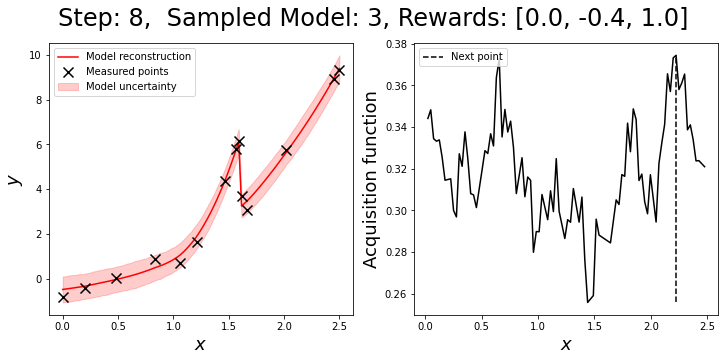

Exploration step 12/15
Using model 2


sample: 100%|██████████| 4000/4000 [01:33<00:00, 42.68it/s, 1023 steps of size 7.78e-04. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.33      0.83      2.28      0.88      3.63     75.54      1.00
         c      3.33      0.38      3.32      2.64      3.89     50.12      1.04
  k_length      0.56      0.28      0.59      0.15      0.99     78.66      1.00
   k_scale      1.11      0.95      0.84      0.07      2.22    110.54      1.01
     noise      1.10      0.40      1.07      0.49      1.65     49.02      1.01
         t      1.34      0.30      1.32      0.94      1.93     20.19      1.04

Number of divergences: 0


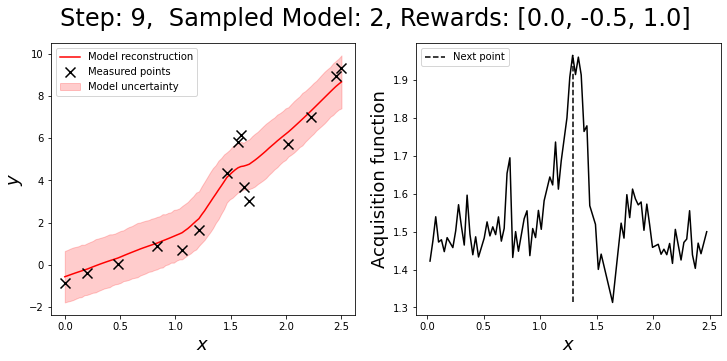

Exploration step 13/15
Using model 3


sample: 100%|██████████| 4000/4000 [01:31<00:00, 43.65it/s, 1023 steps of size 4.41e-03. acc. prob=0.71]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.87      0.15      3.88      3.62      4.09    540.40      1.00
     beta2      2.43      0.09      2.43      2.29      2.57    391.84      1.01
  k_length      0.64      0.25      0.68      0.27      1.00    695.24      1.00
   k_scale      0.49      0.48      0.34      0.03      1.01    492.00      1.00
     noise      0.19      0.10      0.16      0.06      0.31    595.89      1.00
         t      1.60      0.01      1.60      1.59      1.61    706.61      1.00

Number of divergences: 0


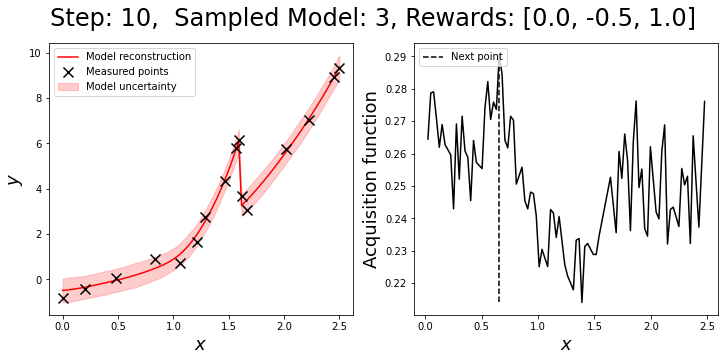

Exploration step 14/15
Using model 2


sample: 100%|██████████| 4000/4000 [01:41<00:00, 39.43it/s, 1023 steps of size 5.02e-05. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      3.30      0.17      3.30      2.97      3.51     14.49      1.12
         c      2.30      0.13      2.32      2.09      2.48      3.09      1.97
  k_length      0.72      0.06      0.73      0.61      0.80      5.52      1.14
   k_scale      2.26      0.31      2.25      1.58      2.66      6.59      1.31
     noise      0.73      0.15      0.73      0.47      0.95      4.83      1.01
         t      1.62      0.02      1.61      1.59      1.66     44.78      1.00

Number of divergences: 0


sample: 100%|██████████| 4000/4000 [01:41<00:00, 39.29it/s, 1023 steps of size 7.45e-05. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      4.45      0.31      4.44      4.00      5.05      7.56      1.08
         c      2.92      0.46      2.78      2.32      3.70      2.89      2.10
  k_length      0.57      0.14      0.60      0.31      0.76      5.45      1.42
   k_scale      2.19      0.53      2.25      1.27      2.94      5.04      1.31
     noise      0.36      0.09      0.33      0.24      0.51      2.85      2.05
         t      1.60      0.01      1.61      1.59      1.62    237.95      1.00

Number of divergences: 0


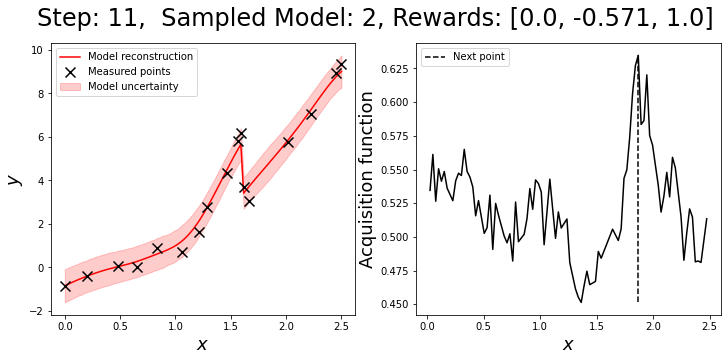

Exploration step 15/15
Using model 3


sample: 100%|██████████| 4000/4000 [02:02<00:00, 32.54it/s, 1023 steps of size 6.08e-04. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta1      3.89      0.13      3.88      3.67      4.08     52.04      1.02
     beta2      2.44      0.07      2.44      2.32      2.57     29.65      1.07
  k_length      0.62      0.26      0.64      0.23      0.98     40.35      1.00
   k_scale      0.39      0.37      0.27      0.05      0.78     54.84      1.01
     noise      0.15      0.06      0.14      0.05      0.23     57.55      1.02
         t      1.60      0.01      1.60      1.59      1.62     58.11      1.00

Number of divergences: 0


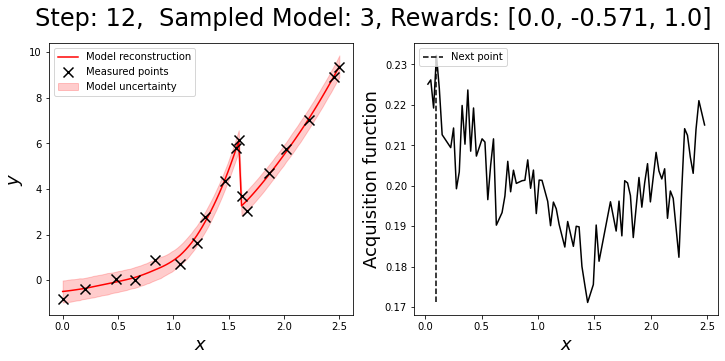

In [10]:
exploration_steps = 15
eps = 0.4
warmup_steps = 3
models = [piecewise1, piecewise2, piecewise3]
model_priors = [piecewise1_priors, piecewise2_priors, piecewise3_priors]
save_reconstruction = True  # available only for exploration phase


onp.random.seed(55)  # rng seed for epsilon-greedy sampling
record = onp.zeros((len(models), 2))
model_choices = []
obj_history = []
# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    obj_all = []
    for i, model in enumerate(models):
        obj, _ = step(model, model_priors[i], X_train, y_train, X_test)
        record[i, 0] += 1
        obj_all.append(jnp.nanmedian(obj).item())  # (one can use integral uncertainty instead of median)
    # 'Reward' a model that has the smallest integral/median uncertainty
    idx = onp.argmin(obj_all)
    model_choices.append(idx)
    record[idx, 1] += 1
    # Store the integral uncertainty
    obj_history.append(obj_all[idx])
    # Compute the next measurement point
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Evaluate the function in the suggested point
    measured_point = y_test[next_point_idx]
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))
# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Run exploration
for e in range(exploration_steps - warmup_steps):
    print("Exploration step {}/{}".format(e+warmup_steps+1, exploration_steps))
    # Choose model according to epsilon-greedy policy
    if onp.random.random() > eps: 
        idx = get_best_model(record)
    else:
        idx = onp.random.randint(len(models))
    model_choices.append(idx)
    print("Using model {}".format(idx+1))
    # Derive acqusition function with the selected model
    obj, m_post = step(models[idx], model_priors[idx], X_train, y_train, X_test, num_restarts=2)
    # Get reward
    r = get_reward(obj_history, obj)
    # Update records
    record = update_record(record, idx, r)
    obj_history.append(jnp.nanmedian(obj).item())
    # Evaluate function in the suggested point
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    measured_point = y_test[next_point_idx]
    if save_reconstruction:    
        # plot current reconstruction and acqusition function
        y_pred, y_sampled = m_post.predict(gpax.utils.get_keys()[1], X)
        plot_results(X_train, y_train, X_test, y_pred, y_sampled, obj, idx+1, record[:, 1],  e=e)
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))

Plot integral/median uncerainty as a function of exploration steps:

(note that for the warm-up steps, we plot only model that produced lowest uncertainty)

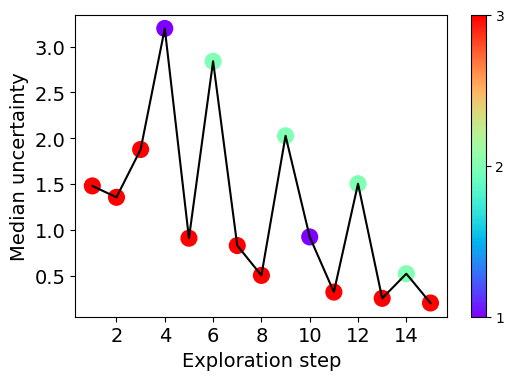

In [11]:
plt.figure(dpi=100)
plt.plot(onp.arange(1, exploration_steps+1), obj_history, c='k')
plt.scatter(onp.arange(1, exploration_steps+1), obj_history,
            c=[m+1 for m in model_choices],
            s=128, cmap='rainbow', alpha=1)
plt.xlabel("Exploration step", fontsize=14)
plt.ylabel("Median uncertainty", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
cbar = plt.colorbar()
cbar.set_ticks([1, 2, 3])

View average reward associated with each model:

(note that it counts the warmup steps where all the models were evaluated)

In [12]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), onp.round(r[1], 3)))

model 1:  counts 5  reward (avg) 0.0
model 2:  counts 7  reward (avg) -0.571
model 3:  counts 9  reward (avg) 1.0


Compute (and plot) each model's prediction over the entire grid using the final set of the discovered point:


sample: 100%|██████████| 4000/4000 [02:08<00:00, 31.06it/s, 1023 steps of size 1.74e-03. acc. prob=0.84]



 Model 1, Reward (avg) 0.0


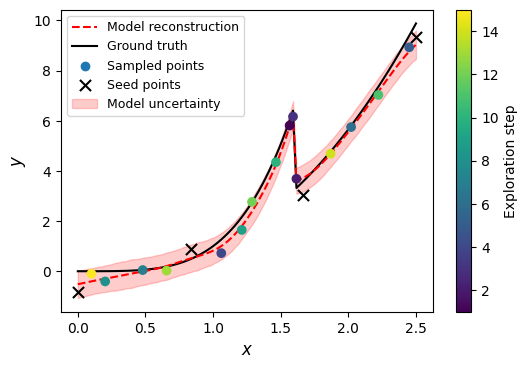

sample: 100%|██████████| 4000/4000 [02:00<00:00, 33.14it/s, 1023 steps of size 1.30e-03. acc. prob=0.79]



 Model 2, Reward (avg) -0.571


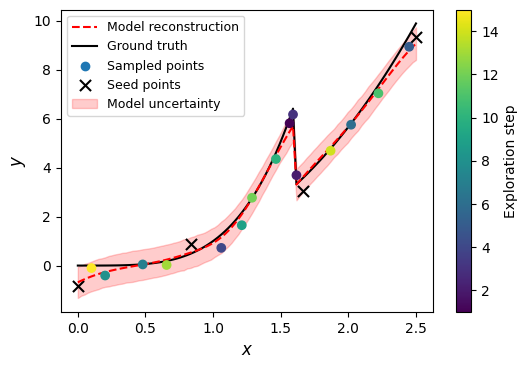

sample: 100%|██████████| 4000/4000 [02:07<00:00, 31.33it/s, 1023 steps of size 3.81e-03. acc. prob=0.72]



 Model 3, Reward (avg) 1.0


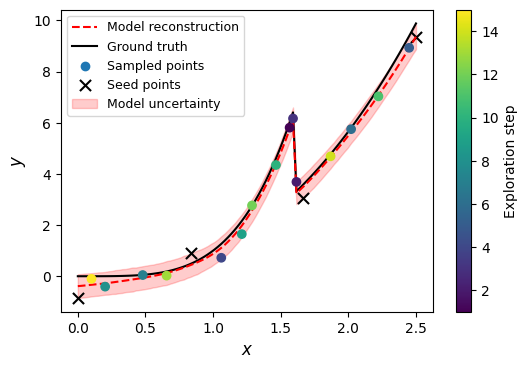

In [13]:
for i, model in enumerate(models):
    # same as in the main loop, we use restarts to help avoiding bad initialization
    _, gp_model = step(model, model_priors[i], X_train, y_train, num_restarts=2, print_summary=0)
    y_pred, y_sampled = gp_model.predict(gpax.utils.get_keys()[1], X)
    print("\n Model {}, Reward (avg) {}".format(i+1, onp.round(record[i, 1], 3)))
    plot_final_result(X_train, y_train, X, y_pred, y_sampled, seed_points=num_seed_points)